In [5]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import kwant
import numpy as np
import scipy
import scipy.ndimage
import scipy.linalg as la
from types import SimpleNamespace
from datetime import datetime
import multiprocessing as mp
import queue
import os
from functools import partial
import csv
%matplotlib inline

In [2]:
vbg = 0.5 
vlead = 0.0
nb_points = 11 
maxB = 5e-05 
magnetic_field = np.linspace(-maxB, maxB, nb_points)
vsg_values = np.linspace(-0.1, -0.4, 3)#np.linspace(-0.3, -0.45, 151) 
maxPhi = np.pi
phase = (-np.pi, np.pi) 

delta = 1.0 
T = delta / 2
eta = 2.5 
gamma = 0.4
at = 5.0
a = 0.4

In [16]:
pot_decay = 20
path = '/home/nefta/thesis/designfiles/hb_lower_part.png'
designfile = '/home/nefta/thesis/designfiles/hb_lower_part.png'
topgate = 1 - scipy.ndimage.imread(designfile, mode='L').T / 255
topgate_gauss = scipy.ndimage.gaussian_filter(topgate, pot_decay)
scattering_region = 1 - scipy.ndimage.imread('/home/nefta/thesis/designfiles/scatteringRegion.png', mode='L').T / 255

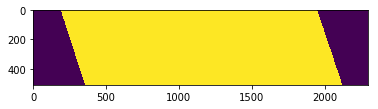

In [17]:
plt.imshow(scattering_region)

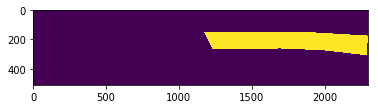

In [6]:
plt.imshow(topgate)

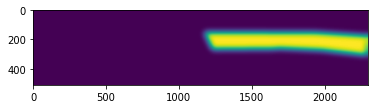

In [8]:
plt.imshow(topgate_gauss)

In [20]:
bilayer =  kwant.lattice.general([(at*np.sqrt(3)/2, at*1/2), (0, at*1)],
                                 [(0, 0.0), (at*1 / (2*np.sqrt(3)), at*1/2), 
                                  (-at*1/(2*np.sqrt(3)), at*1/2), (0, 0)])
a1, b1, a2, b2 = bilayer.sublattices
hoppings1 = (((0, 0), a1, b1), ((0, 1), a1, b1), ((1, 0), a1, b1)) 
hoppings2 = (((0, 0), a2, b2), ((0, -1), a2, b2), ((1, -1), a2, b2))


potential = scipy.interpolate.RectBivariateSpline(
    x=(a*np.arange(topgate_gauss.shape[0])),
    y=(a*np.arange(topgate_gauss.shape[1])),
    z=topgate_gauss, 
    kx=1,
    ky=1,
)

def onsite(site, par):    
    topgate_potential = par.v_sg * potential(site.pos[0], site.pos[1]) 
    mu = (par.v_bg + topgate_potential) / 2 
    delta = - (topgate_potential - par.v_bg) / eta 
    # site.family in (a1, b1)
    if (site.family == a1 or site.family == b1):
        return - mu - delta 
    return -mu + delta

def onsite_lead(site, par):     
    topgate_potential = par.v_lead
    mu = (par.v_bg + topgate_potential) / 2
    delta = - ( topgate_potential - par.v_bg) / eta
    if site.family == a1 or site.family == b1:
        return - mu - delta
    return -mu  + delta


def geomShape(pos):
    #x, y = pos
    if pos[0] < 0 or pos[1] < 0:
        return False
    try:
        # rather round()?
        return scattering_region[int(pos[0] / a), int(pos[1] / a)]
    except IndexError:
        return False

def hop_intra_layer(site1, site2, par): 
    xt, yt = site1.pos 
    xs, ys = site2.pos
    return -par.t * np.exp(-0.5j * np.pi * par.B  * (xt - xs) * (yt + ys))

def hop_inter_layer(site1, site2, par): 
    return -par.gamma1 

def hop_intra_layer_lead(site1, site2, par): 
    return -par.t 

def hop_inter_layer_lead(site1, site2, par): 
    return -par.gamma1 

def leadShape1(pos):
    y = pos[1]
    if y < 0:
        return False
    try:
        return scattering_region[0, int(y / a)]
    except IndexError:
        return False
    
def leadShape2(pos):
    y = pos[1]
    if y < 0:
        return False
    try:
        return scattering_region[-1, int(y / a)]
    except IndexError:
        return False

def trs(m):
    return m.conj()

class TRIInfiniteSystem(kwant.builder.InfiniteSystem):
    def __init__(self, lead, trs):
        """A lead with time reversal invariant modes."""
        self.__dict__ = lead.__dict__
        self.trs = trs

    def modes(self, energy=0, args=()):
        prop_modes, stab_modes = super(TRIInfiniteSystem, self).modes(energy=energy, args=args)
        n = stab_modes.nmodes
        stab_modes.vecs[:, n:(2*n)] = self.trs(stab_modes.vecs[:, :n])
        stab_modes.vecslmbdainv[:, n:(2*n)] =  self.trs(stab_modes.vecslmbdainv[:, :n])
        prop_modes.wave_functions[:, n:] = self.trs(prop_modes.wave_functions[:, :n])
        return prop_modes, stab_modes



In [10]:
def make_system():
    system = kwant.Builder()
    scat_width = scattering_region.shape[0]
    scat_length = scattering_region.shape[1]

    system[bilayer.shape(geomShape, (0.5*a*scat_width, 0.5*a*scat_length))] = onsite 
    system[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings1]] = hop_intra_layer
    system[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2]] = hop_intra_layer
    system[kwant.builder.HoppingKind((0, 0), a1, b2) ] = hop_inter_layer    

    trans_sym_1 = kwant.TranslationalSymmetry(bilayer.vec((-2, 1)))
    lead_1 = kwant.Builder(trans_sym_1)
    lead_1[bilayer.shape(leadShape1, (0, 0.5*a*scat_length))] = onsite_lead
    lead_1[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings1]] = hop_intra_layer_lead
    lead_1[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2]] = hop_intra_layer_lead
    lead_1[kwant.builder.HoppingKind((0, 0), a1, b2)] = hop_inter_layer_lead

    trans_sym_2 = kwant.TranslationalSymmetry(bilayer.vec((2, -1))) #?
    lead_2 = kwant.Builder(trans_sym_2)
    lead_2[bilayer.shape(leadShape2, (0, 0.5*a*scat_length))] = onsite_lead
    lead_2[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings1]] = hop_intra_layer_lead
    lead_2[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2]] = hop_intra_layer_lead
    lead_2[kwant.builder.HoppingKind((0, 0), a1, b2)] = hop_inter_layer_lead
     
    system.attach_lead(lead_1)
    system.attach_lead(lead_2)
    system = system.finalized()
    system.leads = [TRIInfiniteSystem(lead, trs) for lead in system.leads]
    
    return(system)

def super_current(scat_matrix, phi):
    nb_modes = [len(leadInfo.momenta) for leadInfo in scat_matrix.lead_info]
    scat_data = scat_matrix.data
    
    dim1 = int(nb_modes[0]/2)
    dim2 = int(nb_modes[1]/2)
    
    r_a11 = 1j*np.eye(dim1)
    r_a12 = np.zeros((dim1, dim2))
    r_a21 = r_a12.T
    r_a22 = 1j*np.exp(- 1j * phi) * np.eye(dim2)
    r_a = np.bmat([[r_a11, r_a12], [r_a21, r_a22]])
    
    A = (r_a.dot(scat_data) + (scat_data.T).dot(r_a)) / 2
    
    dr_a11 = np.zeros((dim1, dim1))
    dr_a12 = np.zeros((dim1, dim2))
    dr_a21 = dr_a12.T
    dr_a22 = np.exp(- 1j * phi) * np.eye(dim2)
    dr_a = np.bmat([[dr_a11, dr_a12], [dr_a21, dr_a22]])

    dA = (dr_a.dot(scat_data) + (scat_data.T).dot(dr_a)) / 2
    
    dA_total = np.array((dA.T.conj()).dot(A) + (A.T.conj()).dot(dA))
    
    eigenval, eigenvec = la.eigh(A.T.conj().dot(A))
    
    final_eigenval = delta * eigenval ** 0.5 
    final_eigenvec = eigenvec.T
    
    current_complex =  np.sum(
        (vec.T.conj().dot(dA_total.dot(vec)) * np.tanh(val/T)/val)
        for val, vec in zip(final_eigenval, final_eigenvec)
    )
    imag = 0.5 * delta**2 * np.imag(current_complex)
    real = 0.5 * delta**2 * np.real(current_complex)
    absval = 0.5 * delta**2 * np.abs(current_complex)
    #return((absval, real, imag))
    return(absval)


In [11]:
def find_max(func, phase_min, phase_max):
    current = [func(phi) for phi in np.linspace(phase_min, phase_max)]
    currentPeak = max(current)
    return(currentPeak)

def max_current(system, params):
    pos, par = params
    scat_matrix = kwant.smatrix(system, energy=0.0, args=[par])
    func = partial(super_current, scat_matrix)
    currentPeak = find_max(func, phase[0], phase[-1])
    return((pos, currentPeak))

def plot_current(b_field, v_values, current, filename):
    y, x = np.meshgrid(b_field, v_values)
    plt.pcolor(x, y, current)
    cb = plt.colorbar()
    cb.set_label(r'$I_c$')
    plt.ylabel(r'$\varphi_{SG}$', fontsize=14)
    plt.xlabel(r'$B$', fontsize=14)
    plt.savefig(filename)
    return

def worker(system, param_queue, result_queue):
    try:
        while True:
            params = param_queue.get(block=False)
            result = max_current(system, params)
            result_queue.put(result)
            param_queue.task_done()
    except queue.Empty:
        pass



In [18]:
system = make_system()

In [22]:
runtime = datetime.strftime(datetime.today(), '%Y%m%d-%H:%M:%S')
system_params_names = ['vbg', 'vlead', 'maxB', 'nb_points', 
                        'maxVsg', 'minVsg', 'nb_points_vsg', 'decay', 
                        'eta', 'gamma', 'a', 'at', 'delta', 'T', ]
system_params = [str(vbg), str(vlead), str(maxB), str(nb_points), 
                str(vsg_values[-1]), str(vsg_values[0]), str(len(vsg_values)), str(pot_decay), 
                str(eta), str(gamma), str(a), str(at), str(delta), str(T), ]
newpath = path + 'vbg=' + str(vbg) + '-' +  runtime + '/'
if not os.path.exists(newpath):
    os.makedirs(newpath)
system_params_file = newpath + 'params.txt'
with open(system_params_file, 'w' ) as paramfile:
    for name, value in zip(system_params_names, system_params):
        paramfile.write(name + ", " + value + '\n')





In [23]:
param_queue = mp.JoinableQueue()
result_queue = mp.JoinableQueue() 
namespace_args = []

for i, b in enumerate(magnetic_field):
    for j, vsg in enumerate(vsg_values):
        namespace_args.append(((i, j),  SimpleNamespace(v_sg=vsg, v_bg=vbg, v_lead=vlead, t=1, gamma1=gamma, B=b)))
for arg in namespace_args:
    param_queue.put(arg)

timestamp = datetime.now()
nb_cores = mp.cpu_count()
processes = [mp.Process(target=worker, args=(system, param_queue, result_queue)) for i in range(nb_cores)]
for p in processes:
    p.start()
param_queue.join()
results = []
try:
    while True:
        results.append(result_queue.get(block=False))
except queue.Empty:
    pass
print('time for calculation with multiprocessing: ', datetime.now() - timestamp)    



Process Process-11:
Traceback (most recent call last):
  File "/usr/lib64/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib64/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-11-8de949767343>", line 27, in worker
    result = max_current(system, params)
  File "<ipython-input-11-8de949767343>", line 8, in max_current
    scat_matrix = kwant.smatrix(system, energy=0.0, args=[par])
  File "/home/nefta/git/kwant/kwant/solvers/common.py", line 350, in smatrix
    check_hermiticity, False)
  File "/home/nefta/git/kwant/kwant/solvers/common.py", line 179, in _make_linear_sys
    prop, stab = lead.modes(energy, args)
  File "<ipython-input-9-299ba87b739d>", line 78, in modes
    prop_modes, stab_modes =             super(TRIInfiniteSystem, self).modes(energy=energy, args=args)
TypeError: super(type, obj): obj must be an instance or subtype of type
Process Process-10:
Traceba

KeyboardInterrupt: 

In [ ]:
sorted_results = sorted(results, key=lambda value: value[0])
unzipped = list(zip(*sorted_results))
current_values = np.split(np.asarray(unzipped[1]), len(vsg_values))

filename = newpath + 'data.csv' 
with open(filename, 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in current_values:
        writer.writerow(list(row))
pngfile = newpath + 'v_sg=' + str(vsg) + '.png'
plot_current(magnetic_field, vsg_values, np.asarray(current_values), pngfile)
print('output in', filename)